In [20]:
import pandas as pd
adj_close = pd.read_csv('../data/adj_close_prices.csv', index_col=0, parse_dates=True)
adj_close.head()

,BND,SPY,TSLA
Date,,,
2015-01-02,62.573086,172.592865,14.620667
2015-01-05,62.754833,169.475891,14.006000
2015-01-06,62.936535,167.879608,14.085333
2015-01-07,62.974380,169.971588,14.063333
2015-01-08,62.875965,172.987778,14.041333


In [21]:
# Divide the data into training and testing sets for each stock.
train_size = int(len(adj_close) * 0.8)
train, test = adj_close[:train_size], adj_close[train_size:]

In [22]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Normalize TSLA data
scaler = MinMaxScaler()
scaled_tsla = scaler.fit_transform(np.array(train['TSLA']).reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(scaled_tsla)

# Reshape input for LSTM [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_tsla_fit=model.fit(X_train, y_train, epochs=4, batch_size=32)
model_tsla=model

Epoch 1/4


/home/adane/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - loss: 0.0320
Epoch 2/4
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0013
Epoch 3/4
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0012
Epoch 4/4
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 9.9178e-04


In [23]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
result = adfuller(train['BND'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] > 0.05:
    print("Time series is non-stationary. Apply differencing.")
else:
    print("Time series is stationary.")

ADF Statistic: -1.2404679233291844
p-value: 0.6559498011265267
Time series is non-stationary. Apply differencing.


In [24]:
diff_bnd = train["BND"].diff().dropna()

# Re-run the ADF test on the differenced data
from statsmodels.tsa.stattools import adfuller

result_diff = adfuller(diff_bnd)
print(f"ADF Statistic (after differencing): {result_diff[0]}")
print(f"p-value (after differencing): {result_diff[1]}")

if result_diff[1] <= 0.05:
    print("Time series is now stationary after differencing.")
else:
    print("Time series is still non-stationary. Consider further differencing or transformations.")

ADF Statistic (after differencing): -13.08971343747602
p-value (after differencing): 1.799003172623571e-24
Time series is now stationary after differencing.


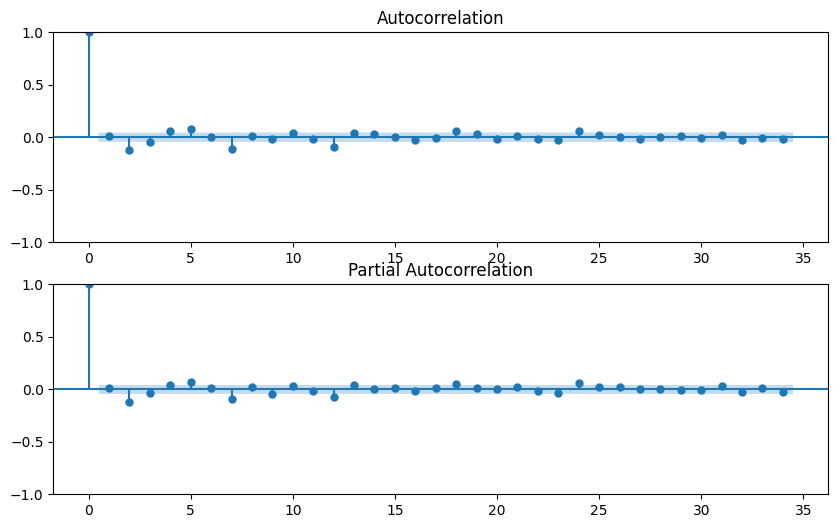

In [25]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(diff_bnd, ax=axes[0])
plot_pacf(diff_bnd, ax=axes[1])
plt.show()

In [26]:
from statsmodels.tsa.arima.model import ARIMA

# Determine (p, d, q) parameters (example values)
p, d, q = 3, 1, 3

# Train ARIMA model for BND
model_bnd = ARIMA(train['BND'], order=(p, d, q))
model_bnd_fit = model_bnd.fit()

print(model_bnd_fit.summary())

/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    BND   No. Observations:                 2028
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 119.871
Date:                Sun, 02 Mar 2025   AIC                           -225.742
Time:                        23:55:28   BIC                           -186.442
Sample:                             0   HQIC                          -211.322
                               - 2028                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0018      4.286      0.234      0.815      -7.399       9.402
ar.L2         -1.0559      1.900     -0.556      0.578      -4.781       2.669
ar.L3          0.4514      3.481      0.130      0.8

/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


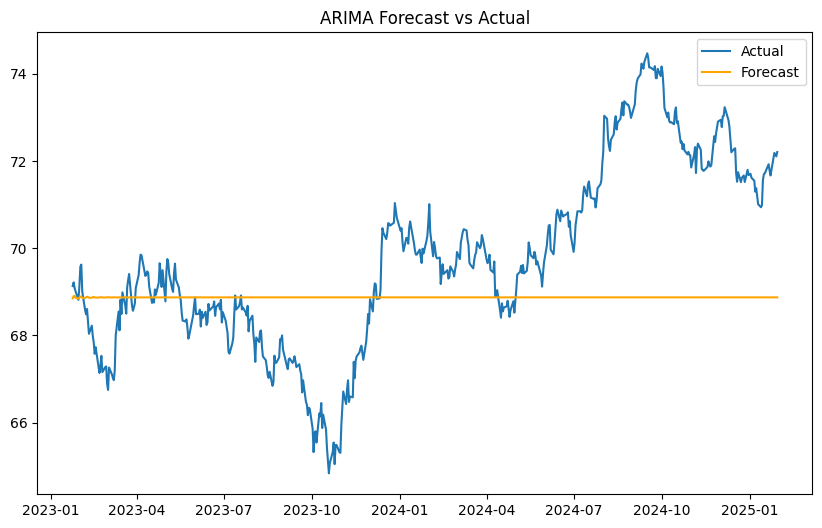

In [27]:
forecast = model_bnd_fit.forecast(steps=len(test["BND"]))

# Compare with actual values
plt.figure(figsize=(10, 6))
plt.plot(test["BND"].index, test["BND"].values, label='Actual')
plt.plot(test["BND"].index, forecast, label='Forecast', color='orange')
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.show()

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Determine seasonal parameters (example values)
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 30

# Train SARIMA model for SPY
model_spy = SARIMAX(train['SPY'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model_spy_fit = model_spy.fit()

print(model_spy_fit.summary())

/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75952D+00    |proj g|=  8.16278D-02

At iterate    5    f=  2.64888D+00    |proj g|=  3.42543D-02

At iterate   10    f=  2.64196D+00    |proj g|=  5.94626D-03

At iterate   15    f=  2.63954D+00    |proj g|=  4.79483D-04

At iterate   20    f=  2.63953D+00    |proj g|=  3.00318D-05

At iterate   25    f=  2.63953D+00    |proj g|=  3.03941D-04

At iterate   30    f=  2.63938D+00    |proj g|=  2.15308D-03

At iterate   35    f=  2.63937D+00    |proj g|=  4.08371D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [29]:
# Forecast TSLA using LSTM
forecast_tsla = model.predict(test['TSLA'])
forecast_tsla = scaler.inverse_transform(forecast_tsla)

# Forecast BND using ARIMA
forecast_bnd = model_bnd_fit.forecast(steps=len(test))

# Forecast SPY using SARIMA
forecast_spy = model_spy_fit.forecast(steps=len(test))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate TSLA (LSTM)
mae_tsla = mean_absolute_error(test['TSLA'], forecast_tsla)
rmse_tsla = np.sqrt(mean_squared_error(test['TSLA'], forecast_tsla))

# Evaluate BND (ARIMA)
mae_bnd = mean_absolute_error(test['BND'], forecast_bnd)
rmse_bnd = np.sqrt(mean_squared_error(test['BND'], forecast_bnd))

# Evaluate SPY (SARIMA)
mae_spy = mean_absolute_error(test['SPY'], forecast_spy)
rmse_spy = np.sqrt(mean_squared_error(test['SPY'], forecast_spy))

print(f"TSLA - MAE: {mae_tsla:.2f}, RMSE: {rmse_tsla:.2f}")
print(f"BND - MAE: {mae_bnd:.2f}, RMSE: {rmse_bnd:.2f}")
print(f"SPY - MAE: {mae_spy:.2f}, RMSE: {rmse_spy:.2f}")

TSLA - MAE: 44.51, RMSE: 65.34
BND - MAE: 1.80, RMSE: 2.29
SPY - MAE: 71.23, RMSE: 88.84


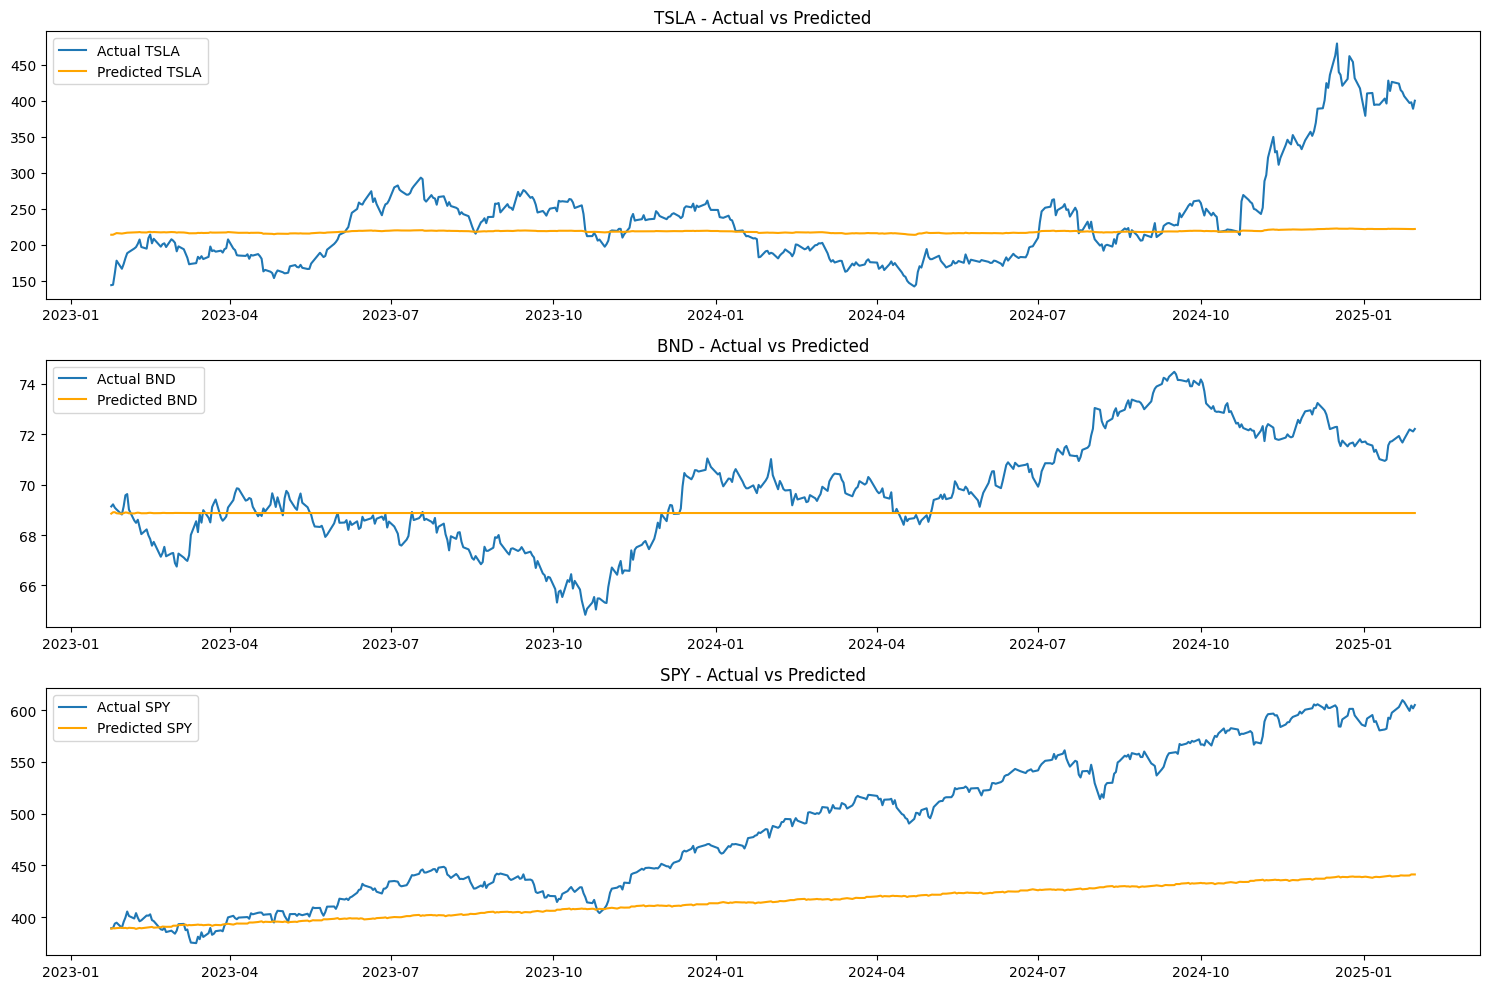

In [31]:
plt.figure(figsize=(15, 10))

# Plot TSLA
plt.subplot(3, 1, 1)
plt.plot(test.index, test['TSLA'], label='Actual TSLA')
plt.plot(test.index, forecast_tsla, label='Predicted TSLA', color='orange')
plt.title('TSLA - Actual vs Predicted')
plt.legend()

# Plot BND
plt.subplot(3, 1, 2)
plt.plot(test.index, test['BND'], label='Actual BND')
plt.plot(test.index, forecast_bnd, label='Predicted BND', color='orange')
plt.title('BND - Actual vs Predicted')
plt.legend()

# Plot SPY
plt.subplot(3, 1, 3)
plt.plot(test.index, test['SPY'], label='Actual SPY')
plt.plot(test.index, forecast_spy, label='Predicted SPY', color='orange')
plt.title('SPY - Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()

# Generate forecasts for Tesla's stock prices for the next 6-12 months.

In [ ]:
import pandas as pd

# Define forecast horizon (180 trading days)
forecast_steps = 180

# Create a date range for the forecast
forecast_index = pd.date_range(start=test["BND"].index[-1], periods=forecast_steps+1, freq='D')[1:]

In [65]:
import numpy as np
forecast_index = pd.date_range(start=test["TSLA"].index[-1], periods=forecast_steps+1, freq='D')[1:]

# Initialize input data for forecasting
future_input = train["TSLA"][-60:]  # Last 60 days as input

# Generate forecasts
forecast_tsla = []
for _ in range(forecast_steps):
    prediction =  model_tsla.predict(np.array([future_input[-60:]]))
    forecast_tsla.append(prediction[0, 0])
    future_input = np.append(future_input, prediction[0, 0])[-60:]

# Inverse transform the forecast
forecast_tsla = scaler.inverse_transform(np.array(forecast_tsla).reshape(-1, 1)).flatten()

# Convert to a Series with dates
forecast_tsla_series = pd.Series(forecast_tsla, index=forecast_index)
print(forecast_tsla_series.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

In [62]:
import pandas as pd

# Ensure the index is in datetime format
test["BND"].index = pd.to_datetime(test["BND"].index)

# Define the forecast horizon (6 months)
forecast_steps = 180 

# Generate a date range for the forecasted values
forecast_index = pd.date_range(start=test["BND"].index[-1], periods=forecast_steps + 1, freq='D', )[1:]

# Fit the ARIMA model
model_bnb_fit = model_bnd.fit()

# Get forecast instead of using .forecast()
forecast_results = model_bnd_fit.get_forecast(steps=forecast_steps)

# Extract mean predictions
forecast_bnb = forecast_results.predicted_mean

# Assign correct datetime index
forecast_bnb.index = forecast_index

# Display forecast
print(forecast_bnb)


2025-01-31    68.849547
2025-02-01    68.901865
2025-02-02    68.904533
2025-02-03    68.863168
2025-02-04    68.842530
                ...    
2025-07-25    68.872413
2025-07-26    68.872413
2025-07-27    68.872413
2025-07-28    68.872413
2025-07-29    68.872413
Freq: D, Name: predicted_mean, Length: 180, dtype: float64


/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [64]:
import pandas as pd

# Ensure the index is in datetime format
test["SPY"].index = pd.to_datetime(test["SPY"].index)

# Define the forecast horizon (6 months)
forecast_steps = 180

# Generate a date range for the forecasted values
forecast_index = pd.date_range(start=test["SPY"].index[-1], periods=forecast_steps + 1, freq='D', )[1:]

# Fit the ARIMA model
model_spy_fit = model_spy.fit()

# Get forecast instead of using .forecast()
forecast_results = model_spy_fit.get_forecast(steps=forecast_steps)

# Extract mean predictions
forecast_spy = forecast_results.predicted_mean

# Assign correct datetime index
forecast_spy.index = forecast_index

# Display forecast
print(forecast_spy)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75952D+00    |proj g|=  8.16278D-02

At iterate    5    f=  2.64888D+00    |proj g|=  3.42543D-02

At iterate   10    f=  2.64196D+00    |proj g|=  5.94626D-03

At iterate   15    f=  2.63954D+00    |proj g|=  4.79483D-04

At iterate   20    f=  2.63953D+00    |proj g|=  3.00318D-05

At iterate   25    f=  2.63953D+00    |proj g|=  3.03941D-04

At iterate   30    f=  2.63938D+00    |proj g|=  2.15308D-03

At iterate   35    f=  2.63937D+00    |proj g|=  4.08371D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [74]:
# Ensure all forecasts are Pandas Series with the same datetime index
# Example: forecast_bnb, forecast_spy, forecast_tsla_series

# Combine forecasts into a DataFrame
forecast_df = pd.DataFrame({
    "BND": forecast_bnb,       # Forecast for BND
    "SPY": forecast_spy,       # Forecast for SPY
    "TSLA": forecast_tsla_series  # Forecast for TSLA
})

# Display the resulting DataFrame
print(forecast_df.head())

                  BND         SPY        TSLA
2025-01-31  68.849547  388.783739  775.781006
2025-02-01  68.901865  389.228457  802.974731
2025-02-02  68.904533  389.066462  846.194824
2025-02-03  68.863168  389.315597  879.769226
2025-02-04  68.842530  389.671199  903.291321


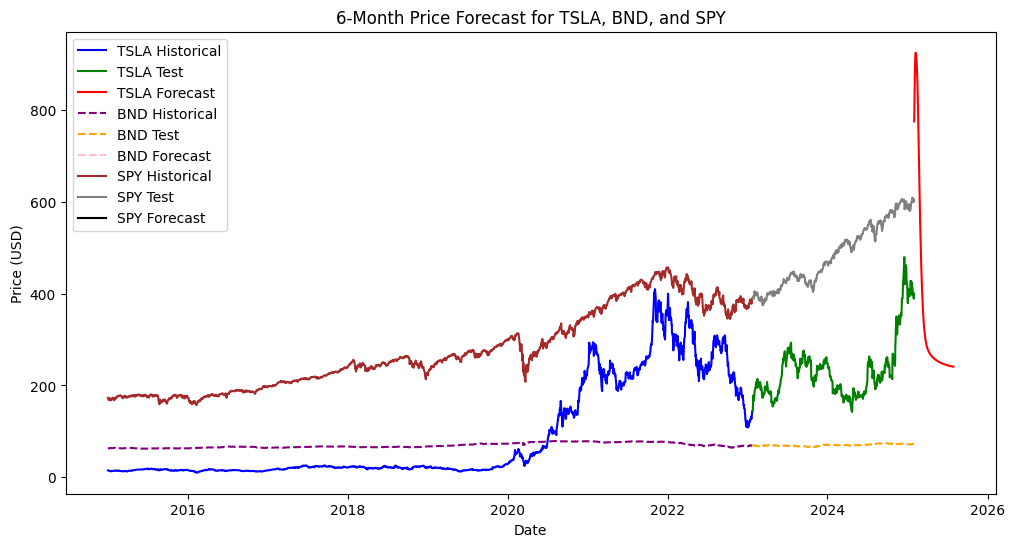

In [71]:
import matplotlib.pyplot as plt

# Plot historical data and forecasts
plt.figure(figsize=(12, 6))

# TSLA
plt.plot(train.index, train['TSLA'], label='TSLA Historical', color='blue')
plt.plot(test.index, test['TSLA'], label='TSLA Test', color='green')
plt.plot(forecast_index, forecast_tsla_series, label='TSLA Forecast', color='red')

# BND
plt.plot(train.index, train['BND'], label='BND Historical', color='purple', linestyle='--')
plt.plot(test.index, test['BND'], label='BND Test', color='orange', linestyle='--')
plt.plot(forecast_index, forecast_bnd_series, label='BND Forecast', color='pink', linestyle='--')

# SPY
plt.plot(train.index, train['SPY'], label='SPY Historical', color='brown')
plt.plot(test.index, test['SPY'], label='SPY Test', color='gray')
plt.plot(forecast_index, forecast_spy_series, label='SPY Forecast', color='black')

plt.title("6-Month Price Forecast for TSLA, BND, and SPY")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

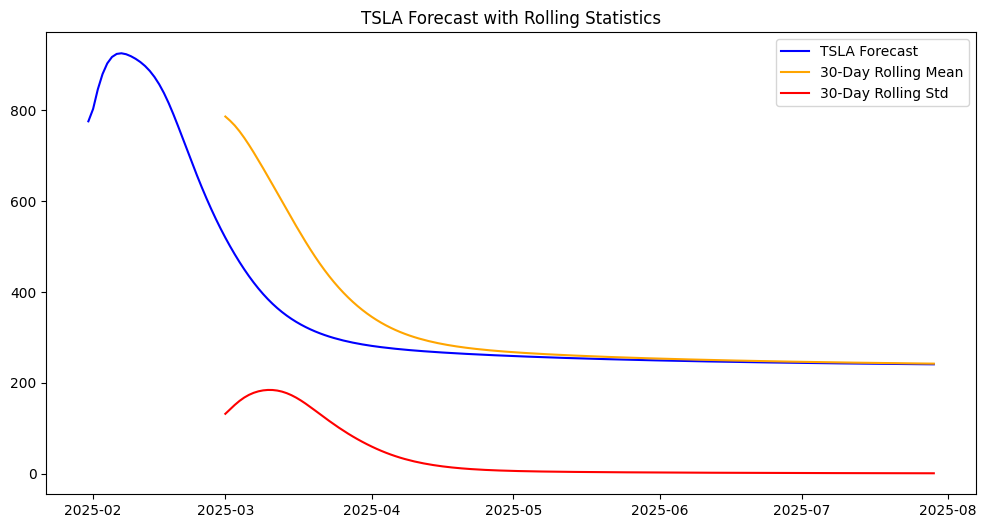

In [72]:
# Calculate rolling statistics for TSLA forecast
tsla_rolling_mean = forecast_tsla_series.rolling(window=30).mean()
tsla_rolling_std = forecast_tsla_series.rolling(window=30).std()

# Plot rolling statistics
plt.figure(figsize=(12, 6))
plt.plot(forecast_index, forecast_tsla_series, label='TSLA Forecast', color='blue')
plt.plot(forecast_index, tsla_rolling_mean, label='30-Day Rolling Mean', color='orange')
plt.plot(forecast_index, tsla_rolling_std, label='30-Day Rolling Std', color='red')
plt.title("TSLA Forecast with Rolling Statistics")
plt.legend()
plt.show()

In [73]:
# Calculate daily returns for TSLA forecast
tsla_returns = forecast_tsla_series.pct_change().dropna()

# Value at Risk (VaR) at 95% confidence level
var_95 = np.percentile(tsla_returns, 5)
print(f"TSLA VaR (95%): {var_95:.4f}")

# Sharpe Ratio
risk_free_rate = 0.02  # Annual risk-free rate
mean_return = tsla_returns.mean() * 252  # Annualized mean return
std_dev = tsla_returns.std() * np.sqrt(252)  # Annualized standard deviation
sharpe_ratio = (mean_return - risk_free_rate) / std_dev
print(f"TSLA Sharpe Ratio: {sharpe_ratio:.4f}")

TSLA VaR (95%): -0.0364
TSLA Sharpe Ratio: -7.5408


In [75]:
# Compute daily returns
returns = forecast_df.pct_change().dropna()

print(returns.head())

                 BND       SPY      TSLA
2025-02-01  0.000760  0.001144  0.035053
2025-02-02  0.000039 -0.000416  0.053825
2025-02-03 -0.000600  0.000640  0.039677
2025-02-04 -0.000300  0.000913  0.026737
2025-02-05  0.000352 -0.000850  0.015658


In [76]:
# Annualize the mean daily returns
annual_returns = returns.mean() * 252  # Assuming 252 trading days in a year
print("Annualized Returns:")
print(annual_returns)

Annualized Returns:
BND     0.000469
SPY     0.068983
TSLA   -1.617745
dtype: float64


In [77]:
# Compute the covariance matrix
cov_matrix = returns.cov() * 252  # Annualize the covariance
print("Covariance Matrix:")
print(cov_matrix)

Covariance Matrix:
               BND           SPY      TSLA
BND   2.428930e-06 -7.764340e-08  0.000010
SPY  -7.764340e-08  3.166400e-04 -0.000007
TSLA  1.024663e-05 -6.819206e-06  0.047169


In [78]:
# Compute annualized volatility
annual_volatility = returns.std() * np.sqrt(252)
print("Annualized Volatility:")
print(annual_volatility)

Annualized Volatility:
BND     0.001559
SPY     0.017794
TSLA    0.217185
dtype: float64


In [79]:
# Define initial weights (e.g., equal weighting)
weights = np.array([0.4, 0.3, 0.3])  # TSLA: 40%, BND: 30%, SPY: 30%

# Ensure weights sum to 1
weights = weights / np.sum(weights)

print("Portfolio Weights:")
print(weights)

Portfolio Weights:
[0.4 0.3 0.3]


In [80]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns

# Compute expected returns and covariance matrix
mu = expected_returns.mean_historical_return(forecast_df)
S = risk_models.CovarianceShrinkage(forecast_df).ledoit_wolf()

# Optimize for maximum Sharpe Ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe(risk_free_rate=risk_free_rate)
cleaned_weights = ef.clean_weights()

print("Optimized Portfolio Weights:")
print(cleaned_weights)

# Portfolio performance
ef.portfolio_performance(verbose=True)

Optimized Portfolio Weights:
OrderedDict({'BND': 0.0, 'SPY': 1.0, 'TSLA': 0.0})
Expected annual return: 7.1%
Annual volatility: 3.2%
Sharpe Ratio: 1.62


/home/adane/anaconda3/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.07123631896273312, 0.031535047877899965, 1.6247420698745783)

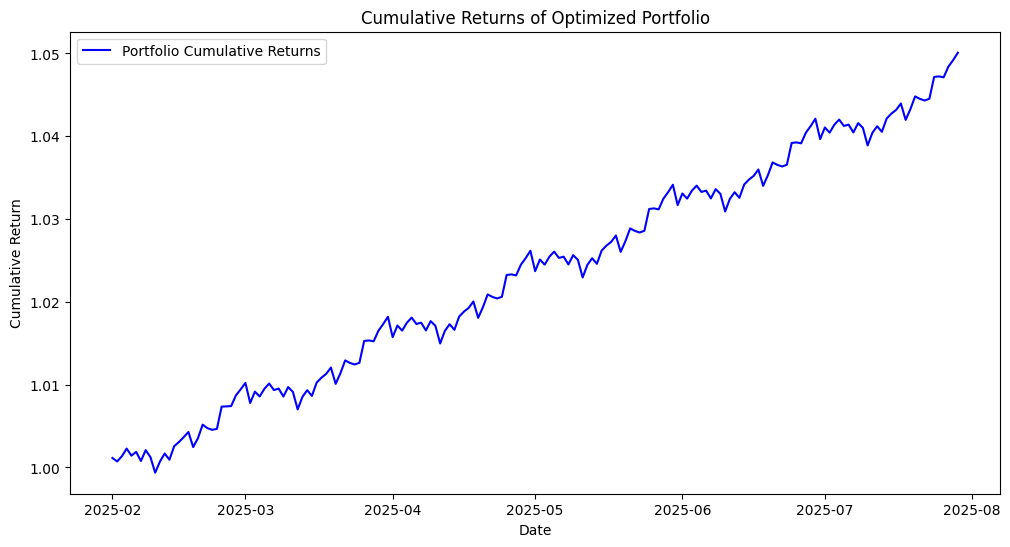

In [81]:
import matplotlib.pyplot as plt

# Compute daily portfolio value
portfolio_value = (forecast_df * weights).sum(axis=1)

# Compute cumulative returns
cumulative_returns = (1 + portfolio_value.pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns.values, label="Portfolio Cumulative Returns", color="blue")
plt.title("Cumulative Returns of Optimized Portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()